In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.6 MB/s eta 0:00:00


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Загрузка данных
train = pd.read_csv('/content/train_data.csv')
test = pd.read_csv('/content/test_data.csv')

In [29]:
# Предобработка данных
categorical_cols = train.select_dtypes(include=['object']).columns.intersection(test.columns)
for col in categorical_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)

In [30]:
# Заполнение пропусков для числовых колонок
numeric_cols = [col for col in train.select_dtypes(include=['float64', 'int64']).columns if col in test.columns]

train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].mean())
test[numeric_cols] = test[numeric_cols].fillna(test[numeric_cols].mean())

In [31]:
# Кодирование категориальных переменных
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)
# Убедимся, что тестовый набор имеет те же колонки, что и тренировочный
test = test.reindex(columns=train.columns, fill_value=0)
# Определение признаков и целевой переменной
X = train.drop('Depression', axis=1)
y = train['Depression']

In [32]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler

In [33]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    n_estimators = trial.suggest_int('n_estimators', 400, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 4)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 4)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    gamma = trial.suggest_float('gamma', 0, 0.5)

    model = XGBClassifier(
        colsample_bytree=colsample_bytree,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        eval_metric='auc',
        use_label_encoder=False,
        random_state=607
    )

    # Используем кросс-валидацию для оценки метрики ROC-AUC на тренировочных данных
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

In [47]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=607))
optuna.logging.set_verbosity(optuna.logging.WARNING)

def log_best_trial(study, trial):
    if study.best_trial == trial:
        print(f"New best trial: {trial.number} with value: {trial.value} and params: {trial.params}")
study.optimize(objective, n_trials=100,callbacks=[log_best_trial])

# Не стала дожиться полностью окончания, так как может занять очень много времени

New best trial: 0 with value: 0.9741431034578565 and params: {'colsample_bytree': 0.9241441149445456, 'n_estimators': 480, 'learning_rate': 0.01934695515938726, 'reg_lambda': 0.995746986500277, 'reg_alpha': 0.7922495581786353, 'max_depth': 3, 'gamma': 0.00960148482380424}


[W 2025-05-27 20:54:15,653] Trial 1 failed with parameters: {'colsample_bytree': 0.1621141939217663, 'n_estimators': 866, 'learning_rate': 0.01830911692556304, 'reg_lambda': 2.9106714720433975, 'reg_alpha': 2.3081746881941307, 'max_depth': 8, 'gamma': 0.2014396057468147} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-33-842b728d1092>", line 26, in objective
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_valid

KeyboardInterrupt: 

In [48]:
best_params = study.best_params
best_score = study.best_value
print(f"Best Hyperparameters: {best_params}")
print(f"Best ROC-AUC (CV): {best_score:.6f}")

Best Hyperparameters: {'colsample_bytree': 0.9241441149445456, 'n_estimators': 480, 'learning_rate': 0.01934695515938726, 'reg_lambda': 0.995746986500277, 'reg_alpha': 0.7922495581786353, 'max_depth': 3, 'gamma': 0.00960148482380424}
Best ROC-AUC (CV): 0.974143


In [49]:
# Обучение модели с оптимальными гиперпараметрами
best_xgb = XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    max_depth=best_params['max_depth'],
    gamma=best_params['gamma'],
    eval_metric='auc',
    use_label_encoder=False,
    random_state=607
)

In [50]:
# Обучаем модель на всей тренировочной выборке
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9241441149445456, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.00960148482380424,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01934695515938726,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=480, n_jobs=None,
              num_parallel_tree=None, random_state=607, ...)

In [51]:
# Делаем предсказания и оцениваем качество на тестовой выборке
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])

In [52]:
print(f'Test accuracy: {accuracy:.4f}')
print(f'Test ROC-AUC: {roc_auc:.6f}')
print(classification_report(y_test, y_pred))

Test accuracy: 0.9355
Test ROC-AUC: 0.973360
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23061
           1       0.84      0.80      0.82      5079

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.93      0.94      0.93     28140



In [53]:
# --- Анализ важности признаков ---
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

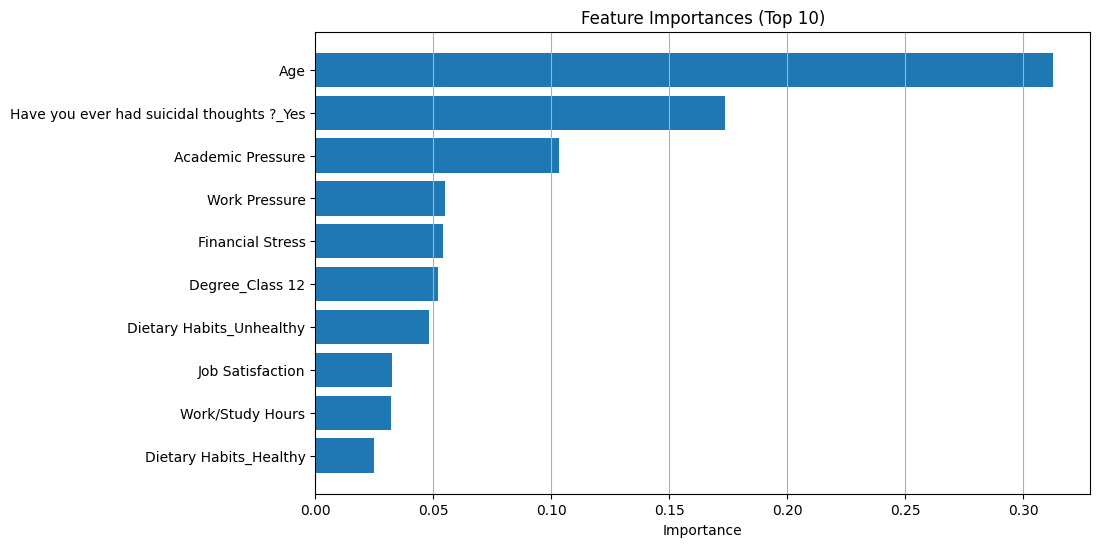

In [56]:
top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances (Top 10)')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [57]:
# --- Визуализация кривой обучения по метрике AUC ---
results = best_xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(epochs)

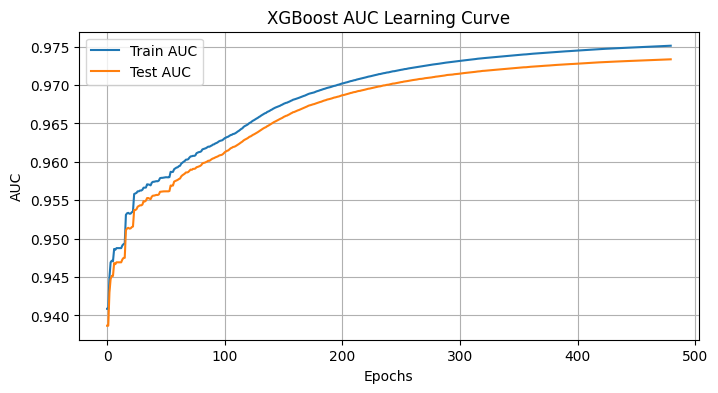

In [58]:
plt.figure(figsize=(8, 4))
plt.plot(x_axis, results['validation_0']['auc'], label='Train AUC')
plt.plot(x_axis, results['validation_1']['auc'], label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('XGBoost AUC Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

**Выводы**: Модель достигла точности на тестовой выборке 0.9355, что указывает на высокую степень правильных предсказаний. Это свидетельствует о том, что модель хорошо справляется с задачей классификации. На бейзлайновой модели она достигала 0.816. Мы могли получить более точную модель, если бы потратили больше времени на этапе исследования с помощью библиотеки Optuna для оптимизации гиперпараметров модели.

Также важно отметить, что значение ROC-AUC составило 0.973360, что говорит о высокой способности модели различать классы. Precision для класса 0 (отсутствие депрессии) составил 0.96, что означает, что 96% предсказаний этого класса были верными. Recall для класса 0 равен 0.97, что указывает на то, что модель правильно идентифицировала 97% всех истинных отрицательных примеров. Для класса 1 (наличие депрессии) precision составил 0.84, а recall — 0.80. Это говорит о том, что модель имеет некоторые трудности с предсказанием положительных примеров, но все же демонстрирует приемлемую производительность. F1-score для класса 1 равен 0.82, что является хорошим показателем, учитывая, что этот класс менее представлен в данных. Это значение указывает на сбалансированное соотношение между precision и recall для класса 1

Дополнительно я вывела наиболее важные признаки влияния на наличие депрессии. Наиболее важным признаком, влияющим на предсказания модели, является Возраст (Importance: 0.312664). Другими значимыми признаками являются Наличие суицидальных мыслей (Importance: 0.173578) и Академическое давление (Importance: 0.103316). Признаки, такие как Финансовый стресс и Нездоровые диетические привычки, также имеют заметное влияние на предсказания. На основе этих данных можно работать привинтивно с факторами и особенно следить за пациентами в определенном возрасте.

В целом, модель демонстрирует высокую производительность и способность к классификации, что делает ее полезной для выявления депрессии на основе предоставленных данных. Однако стоит обратить внимание на улучшение предсказаний для класса 1, возможно, путем дальнейшей настройки модели или использования методов обработки дисбаланса классов.